# 2-component model testing

In [1]:
using Plots # WARNING: the "plot" parameter will overwrite the plot function
using BenchmarkTools
using LaTeXStrings
using Distributions
using Statistics
using Printf
using Distributed
import Random: seed!
using SpecialFunctions
using NumericalIntegration
using LinearAlgebra
include("AffineInvariantMCMC.jl")

save_chain (generic function with 1 method)

In [30]:
# Adjust parameters relative to imported parameter file

include("../params.py")

vmin = Float64(vmin)
vesc_guess = Float64(vesc_guess)
sigmapriormin = Float64(sigmapriormin)
kpriormax = Float64(kpriormax)
fs_sausage_min = Float64(fs_sausage_min)
fs_sausage_max = Float64(fs_sausage_max)
inverse_vesc_prior = Bool(inverse_vesc_prior)
outlier = Bool(outlier)
sausage = Bool(sausage)

if inverse_vesc_prior
    vesc_guess = 1.0 / vesc_guess
end


# Create mock data

The mock data we will create is drawn from the distribution $f$ which has PDF 
$$f(v| v_{esc},k) = \frac{k+1}{v_{esc}{}^{k+1}} (v_{esc} - v)^k \quad,\quad v\in[0,v_{esc}]$$

and CDF
$$ \text{CDF}_f(v) =  \left( 1 - \frac{v}{v_{esc}} \right)^{k+1} -1 \quad,\quad v\in[0,v_{esc}]$$

which has inverse 
$$  \text{CDF}_f{}^{-1}(y) = v_{esc}\left[ 1 - (1-y)^{\frac{1}{k+1}}  \right] \quad,\quad y\in[0,1] $$

We need the inverse CDF to generate samples from this distribution. Note also that the log likelihood is given by
$$ Log\left(\text{Likelihood} (D|v_{esc},k)  \right) = \sum_d Log(f(d|vesc,k)  ) $$

for a dataset D consisting of datapoints $d$, where each term is of the form
$$  Log(f(d|vesc,k)  ) =  Log(k+1) - (k+1)Log(v_{esc}) + k~Log(v_{esc} - v) $$

In [3]:
function powerlaw_PDF(v,x)
    vesc,k = x
    return ( (k+1)*(vesc)^(-k-1) ) * (vesc - v)^k 
end

function powerlaw_inverse_CDF(y,x)
    vesc,k = x
    return vesc*( 1.0 - (1.0-y)^( 1.0/(k+1.0) ) )
end

powerlaw_inverse_CDF (generic function with 1 method)

### Define helper functions

In [4]:
function generate_samples(N,inverse_CDF::Function,x)
    # To sample from a distribution we perform inverse transform sampling, for which the inverse CDF is required
    uniform_random_numbers = rand(Float64,N)
    
    return map( num -> inverse_CDF(num,x) , uniform_random_numbers )
end

generate_samples (generic function with 1 method)

### Sample from distribution to obtain data which we will fit via MCMC

We generate data with a specific escape velocity and $k$ to use in our parameter fit later

In [5]:
target_vesc = 550.0
target_k = 3.0
target_x = [target_vesc,target_k]
num_samples = 10000

target_data = generate_samples(num_samples,powerlaw_inverse_CDF,target_x);

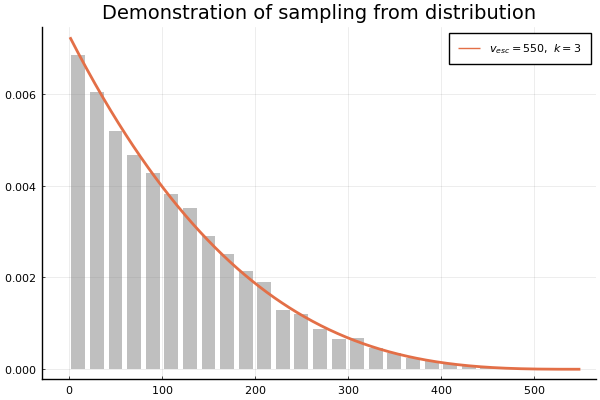

In [6]:
pyplot()

histogram(target_data, normed = true,
                    bins = 25,
                    title = "Demonstration of sampling from distribution",
                    alpha = 0.5,
                    bar_width = 15,
                    linewidth = 0,
                    color = "gray" ,
                    label = ""
                    )

v_test = collect(1:1:550)
plot!(v_test, map(v -> powerlaw_PDF(v,[550.0,3.0]) , v_test) ,
                    linewidth = 2,
                    #color = "red",
                    label = L"v_{esc}=550,~k=3"
                    )

In [7]:
target_data_err = 0.05.*target_data
target_data_err'

1×10000 adjoint(::Vector{Float64}) with eltype Float64:
 0.310513  1.96464  11.1186  1.15621  …  15.6395  15.7484  0.514131  4.75317

In [8]:
target_data'

1×10000 adjoint(::Vector{Float64}) with eltype Float64:
 6.21025  39.2928  222.372  23.1241  …  312.79  314.967  10.2826  95.0634

In [9]:
mask = target_data .> vmin
target_data = target_data[mask]
target_data_err = target_data_err[mask];
target_data'

1×859 adjoint(::Vector{Float64}) with eltype Float64:
 309.456  346.405  260.553  313.907  …  300.567  281.932  312.79  314.967

# Define MCMC functions and parameters

In [10]:
include("functions_MCMC.jl")

lnprob (generic function with 10 methods)

# Use MCJulia to perform sampling

### Parameters and initial conditions for walkers

In [34]:
# Parameters and initial positions of walkers
if sausage
    initial_guess_dist = MvNormal(zeros(6),Diagonal([40, 0.3, 1.0, 1.0, 0.15, 0.1]))
    initial_guess_onewalker = [vesc_guess, k_guess, frac_guess, sigma_guess, k_sausage_guess, frac_sausage_guess]
else
    initial_guess_dist = MvNormal(zeros(4),Diagonal([40, 0.3, 1.0, 1.0]))
    initial_guess_onewalker = [vesc_guess, k_guess, frac_guess, sigma_guess]
end

a = 5.0     # affine-invariant MCMC scale parameter (see http://msp.org/camcos/2010/5-1/p04.xhtml) 
thin = 1
ndims = length(initial_guess_onewalker)

# there must be a cleaner way of doing the below. Maybe define centers as initial_guess_onewalker rather than zeros?
initial_guess = copy(transpose(reduce(hcat, [initial_guess_onewalker + vec(rand(initial_guess_dist , 1))  for _ in 1:nwalkers]) ) )

quantile_list = [0.16, 0.5, 0.84];


Starting multi-threaded sampling...


In [35]:
initial_guess

200×4 Matrix{Float64}:
 505.964  2.27335   -9.97493  6.8239
 492.374  2.37079  -11.7346   5.61265
 502.924  2.15586  -12.3124   4.63897
 501.98   1.93741  -12.4444   8.52432
 493.307  2.36003  -10.2531   6.27072
 499.841  1.53668  -12.0785   6.77686
 493.702  1.63949  -11.6268   5.20341
 503.528  2.00474  -10.5499   6.49768
 501.503  2.25509  -11.7942   6.90089
 504.861  1.70311  -10.8755   6.13008
   ⋮                          
 499.488  1.76361  -11.0021   7.05264
 505.757  2.84061   -9.99233  7.86897
 507.172  2.67675  -10.9187   7.55798
 500.484  2.16132  -11.5471   6.53675
 504.805  1.88319  -11.4943   6.45981
 501.256  2.05714  -12.2497   7.53345
 497.041  2.41146  -11.57     7.43323
 496.837  2.63976  -13.1754   5.86099
 493.331  2.04997  -11.5432   4.49256

In [36]:
seed!(0)
S = Sampler(nwalkers, ndims, lnprob, a,     # Now set the args for the function lnprob after "theta" (the current parameters of the analysis)
            (target_data, target_data_err, vmin, outlier, 
            kpriormin, kpriormax, sigmapriormin, inverse_vesc_prior,
            sausage, fs_sausage_min, fs_sausage_max)
            )

Sampler(200, 4, lnprob, 5.0, Array{Float64, 3}(undef, 200, 4, 0), Matrix{Float64}(undef, 200, 0), 0, 0, ([309.45557626203214, 346.404810122499, 260.55337925901995, 313.90667700466577, 300.58393447024775, 270.3421692009262, 269.1059575649383, 438.09644874181834, 284.08175959057724, 280.9511584682093  …  323.5102403304617, 263.62237416020713, 285.2404601233866, 312.0629062624341, 349.03821397630884, 315.0408227255694, 300.56666963643727, 281.93206737752854, 312.7898876832701, 314.96733262275035], [15.472778813101607, 17.32024050612495, 13.027668962950997, 15.69533385023329, 15.029196723512388, 13.51710846004631, 13.455297878246917, 21.904822437090917, 14.204087979528863, 14.047557923410466  …  16.175512016523086, 13.181118708010358, 14.26202300616933, 15.603145313121708, 17.451910698815443, 15.752041136278471, 15.028333481821864, 14.096603368876428, 15.639494384163505, 15.748366631137518], 250.0, true, 0.1, 20.0, 6.0, false, false, 0.0, 1.0), dummy_callback)

In [37]:
Threads.nthreads()

4

In [38]:
burnin_final_state = sample(S, initial_guess, nsamples_burnin, thin, false)

Starting multi-threaded sampling...


200×4 Matrix{Float64}:
 527.384  2.67112   -8.1571   7.55991
 529.298  2.92412  -10.7562   6.09285
 497.875  2.29415   -8.81138  6.76901
 519.82   2.4149    -8.25441  7.43417
 528.331  2.78853   -7.91569  7.41886
 498.24   2.23425  -11.1536   7.92112
 538.917  2.92258   -8.86139  6.23004
 567.558  3.03969   -9.01505  7.22508
 533.223  2.86407  -13.4284   7.14133
 516.049  2.60983   -9.23343  7.99257
   ⋮                          
 536.995  3.02253  -12.1336   6.31321
 569.916  3.64549  -11.2622   7.55663
 564.586  3.4956   -12.2434   6.65993
 506.185  2.28637   -7.98221  7.03079
 525.498  2.53411   -9.87201  6.4247
 551.352  3.26325  -10.6539   6.82804
 495.475  2.49848  -10.3202   6.98504
 491.162  1.98586  -12.8456   6.56402
 540.472  2.84808   -9.80141  6.40221

In [39]:
S.accepted

19204

In [40]:
S.iterations

79996

In [41]:
sample(S, burnin_final_state, nsamples, thin, true)  # (sampler, starting point, number of steps, thinning factor for data, store chain?)
#println("acceptance ratio: $(S.accepted / S.iterations)")

Starting multi-threaded sampling...


200×4 Matrix{Float64}:
 508.24   2.33021  -12.1264   6.088
 523.97   2.50558  -12.4775   6.43772
 510.191  2.50727  -11.3965   7.23571
 542.133  3.04587  -12.6844   7.30475
 522.682  2.88083  -11.7884   7.84126
 471.33   1.75596  -13.5626   7.78825
 532.94   2.88899  -12.6095   7.26495
 497.597  2.21475  -11.9273   6.32405
 490.895  1.91266  -10.8529   7.42841
 517.9    2.71295   -7.96782  6.31429
   ⋮                          
 503.32   2.44122  -12.5663   7.80954
 531.358  2.9873   -12.1136   6.65199
 573.096  3.46921   -8.02462  6.65709
 511.868  2.50124  -10.287    7.09589
 522.78   2.66591  -13.6447   7.37753
 538.024  2.84292  -12.9356   6.56185
 492.778  2.06482   -7.40763  7.5873
 524.751  2.72616  -11.4671   6.35526
 567.406  3.36665  -10.3791   7.32227

In [42]:
S.accepted

115177

In [43]:
S.iterations

479984

In [66]:
vesc_posterior = flat_chain(S)[1,:]
k_posterior = flat_chain(S)[2,:]
frac_posterior = flat_chain(S)[3,:]
sigma_out_posterior = flat_chain(S)[4,:];

In [ ]:
vesc_posterior'

In [61]:
rejected_mask = vesc_posterior .== 0.0
deleteat!(vesc_posterior, rejected_mask)
deleteat!(k_posterior, rejected_mask)
deleteat!(frac_posterior, rejected_mask)
deleteat!(sigma_out_posterior, rejected_mask);

In [62]:
vesc_posterior'

1×95979 adjoint(::Vector{Float64}) with eltype Float64:
 518.017  507.753  518.444  523.901  …  500.008  523.759  492.954  622.391

### Process the data

In [48]:
# Establish estimates of parameters via median and expected error on these estimates
vesc_quantiles = quantile(vesc_posterior, quantile_list)
k_quantiles = quantile(k_posterior, quantile_list)


vesc_median = vesc_quantiles[2]
vesc_lower_1sigma = vesc_median - vesc_quantiles[1]
vesc_upper_1sigma = vesc_quantiles[3] - vesc_median

k_median = k_quantiles[2]
k_lower_1sigma = k_median - k_quantiles[1]
k_upper_1sigma = k_quantiles[3] - k_median;

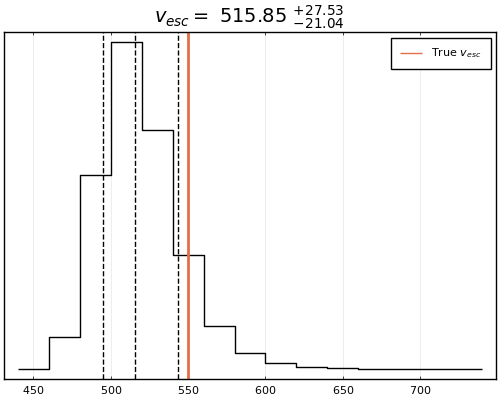

In [55]:
vplot = plot(vesc_posterior,
            title ="\$v_{esc} =\$ $(@sprintf("%.2f", vesc_median)) \$ ^{+$(@sprintf("%.2f", vesc_upper_1sigma))}_{-$(@sprintf("%.2f", vesc_lower_1sigma))}\$ ",
            #alpha = 0.5,
            seriestype=:stephist,
            bins = 25,
            normed = true,
            #bar_width = 15,
            #linewidth = 0,
            #color = "gray" ,
            lc="black",
            label = "",
            size=(500,400),
            framestyle = :box,
            yticks=false
            )
vline!([target_vesc], lw = 2, label = L"True $v_{esc}$")

vline!(vesc_quantiles , ls=:dash, color="black",lw=1,label="" )

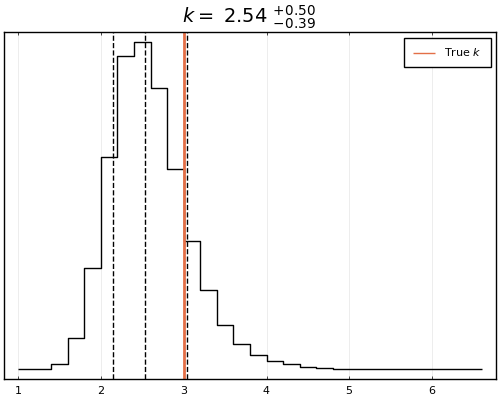

In [51]:
kplot = plot(k_posterior, normed = true,
                    bins = 25,
                    title = "\$k =\$ $(@sprintf("%.2f", k_median)) \$ ^{+$(@sprintf("%.2f", k_upper_1sigma))}_{-$(@sprintf("%.2f", k_lower_1sigma))}\$ ",
                    #alpha = 0.5,
                    #bar_width = 15,
                    #linewidth = 0,
                    #color = "gray" ,
                    lc="black",
                    label = "",
                    seriestype=:stephist,
                    size=(500,400),
                    framestyle = :box,
                    yticks=false
                    )
vline!([target_k], lw = 2, label = L"True $k$")

vline!( k_quantiles, ls=:dash, color="black",lw=1, label="")

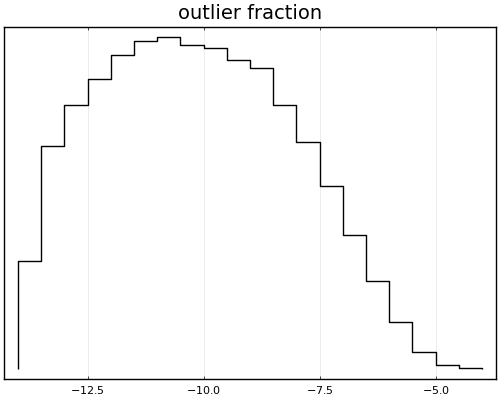

In [63]:
fracplot = plot(frac_posterior,
            title ="outlier fraction",
            #alpha = 0.5,
            seriestype=:stephist,
            bins = 25,
            normed = true,
            #bar_width = 15,
            #linewidth = 0,
            #color = "gray" ,
            lc="black",
            label = "",
            size=(500,400),
            framestyle = :box,
            yticks=false
            )

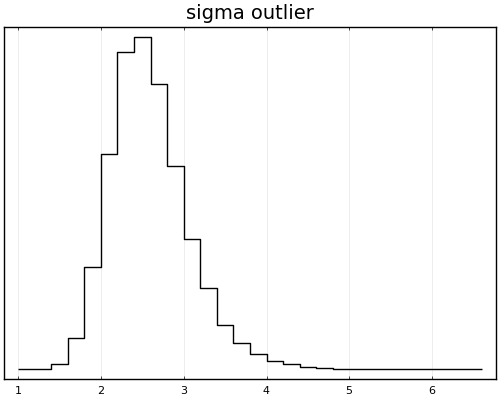

In [65]:
sigma_out_plot = plot(sigma_out_posterior,
            title ="sigma outlier",
            #alpha = 0.5,
            seriestype=:stephist,
            bins = 25,
            normed = true,
            #bar_width = 15,
            #linewidth = 0,
            #color = "gray" ,
            lc="black",
            label = "",
            size=(500,400),
            framestyle = :box,
            yticks=false
            )

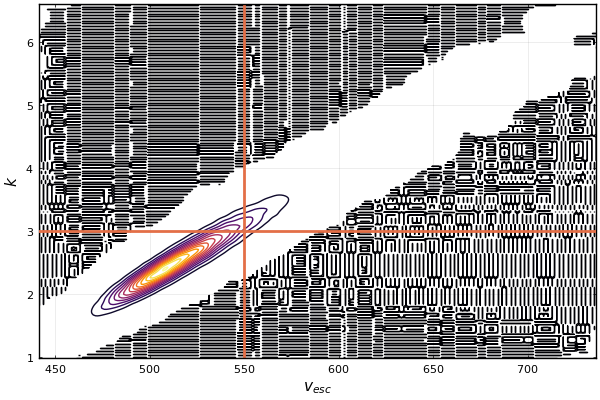

In [56]:
using StatsPlots, KernelDensity
dens = kde((vesc_posterior,k_posterior))
p3 = plot(dens,
    #levels = 0.002:0.1:5.0,
    colorbar=false,
    figsize=(400,400),
    xlabel=L"$v_{esc}$",
    ylabel=L"$k$",
    framestyle = :box
    )

vline!([target_vesc], lw = 2,label="")
hline!([target_k], lw = 2,color=2,label="")

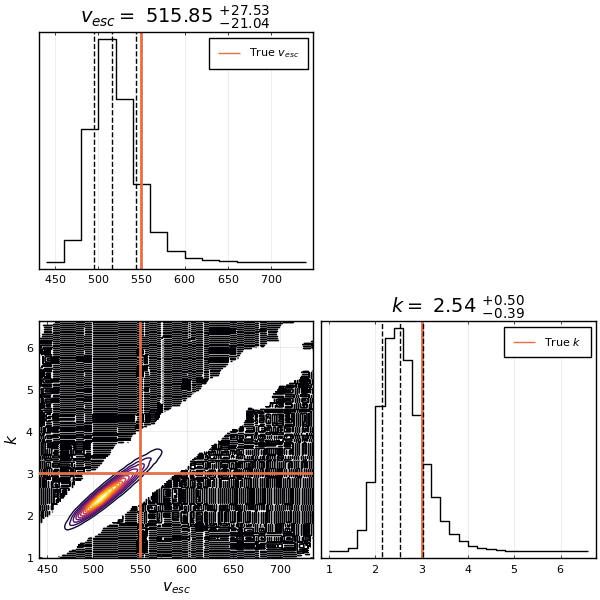

In [57]:
l = @layout [a _ ; b c]

corner = plot(vplot,p3, kplot, layout = l, size=(600,600))

In [ ]:
#savefig(corner, "100000_corner_julia_affine.png")